## Importing all dependencies for the Notebook


In [20]:
import os, sys
import findspark
from pathlib import Path
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, min as spark_min, max as spark_max,
    avg, length, to_timestamp, expr
)
import time 
import pandas as pd 
import matplotlib.pyplot as plt 


## Initializing Java Home for Spark

In [ ]:
print("Python executable:", sys.executable)
print("Python version   :", sys.version)
print("JAVA_HOME before :", os.environ.get("JAVA_HOME"))

JAVA_HOME = "/opt/homebrew/Cellar/openjdk@11/11.0.29/libexec/openjdk.jdk/Contents/Home"
os.environ["JAVA_HOME"] = JAVA_HOME
os.environ["PATH"] = os.path.join(JAVA_HOME, "bin") + ":" + os.environ["PATH"]

print("JAVA_HOME after  :", os.environ.get("JAVA_HOME"))

import subprocess
print("\njava -version from this kernel:")
print(subprocess.check_output(["java", "-version"], stderr=subprocess.STDOUT).decode())

findspark.init()

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
        .appName("test_jvm")
        .getOrCreate()
)

print("\nSpark version:", spark.version)

# Tiny test job
spark.range(5).show()


In [ ]:
try:
    project_root = Path(
        subprocess.check_output(["git", "rev-parse", "--show-toplevel"])
        .decode()
        .strip()
    )
except Exception:
    project_root = Path.cwd().parent

print("PROJECT ROOT:", project_root)

raw_dir = project_root / "data" / "raw"
print("RAW DATA DIR:", raw_dir)

spark = (
    SparkSession.builder
        .appName("IRA_Tweets_Task1")
        .master("local[*]")
        .config("spark.driver.memory", "6g")      # adjust down/up depending on your RAM
        .config("spark.executor.memory", "6g")    # local = same as driver
        .config("spark.sql.shuffle.partitions", "4")
        .getOrCreate()
)

df = (
    spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .option("multiLine", "true")
        .option("escape", "\"")
        .csv(str(raw_dir))
)

df.printSchema()
print("Total rows:", df.count())

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")



## 

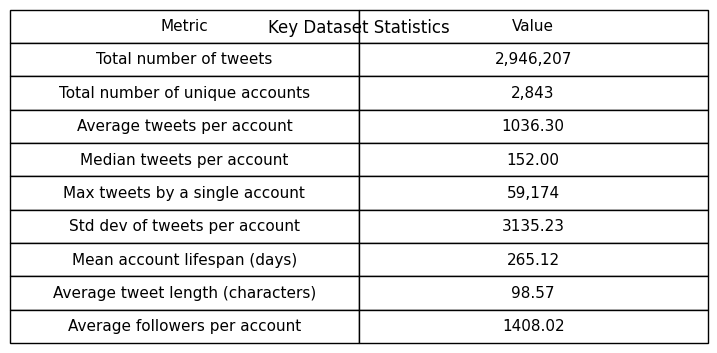

In [ ]:
# timestamp column
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
df_time = df.withColumn(
    "publish_ts",
    to_timestamp("publish_date", "M/d/yyyy H:mm")
)

# global accounts
total_tweets = df.count()
n_accounts = df.selectExpr("count(distinct author) as n").first()["n"]

# / account stats
acct_stats_spark = (
    df_time.groupBy("author")
           .agg(
               count("*").alias("n_tweets"),
               spark_min("publish_ts").alias("first_ts"),
               spark_max("publish_ts").alias("last_ts"),
               avg("followers").alias("avg_followers")
           )
)

acct_stats = acct_stats_spark.toPandas()

# lifespan
acct_stats["lifespan_days"] = (
    (acct_stats["last_ts"] - acct_stats["first_ts"])
    .dt.total_seconds() / 86400.0
).clip(lower=0)

# acc level metrics
avg_tweets = acct_stats["n_tweets"].mean()
median_tweets = acct_stats["n_tweets"].median()
max_tweets = acct_stats["n_tweets"].max()
std_tweets = acct_stats["n_tweets"].std()

mean_lifespan = acct_stats["lifespan_days"].mean()
avg_followers_per_account = acct_stats["avg_followers"].mean()

# avg tweet length 
avg_tweet_length = (
    df.select(avg(length("content")).alias("avg_len"))
      .first()["avg_len"]
)

# defining stats table 
stats_df = pd.DataFrame({
    "Metric": [
        "Total number of tweets",
        "Total number of unique accounts",
        "Average tweets per account",
        "Median tweets per account",
        "Max tweets by a single account",
        "Std dev of tweets per account",
        "Mean account lifespan (days)",
        "Average tweet length (characters)",
        "Average followers per account",
    ],
    "Value": [
        f"{total_tweets:,}",
        f"{n_accounts:,}",
        f"{avg_tweets:.2f}",
        f"{median_tweets:.2f}",
        f"{max_tweets:,}",
        f"{std_tweets:.2f}",
        f"{mean_lifespan:.2f}",
        f"{avg_tweet_length:.2f}",
        f"{avg_followers_per_account:.2f}",
    ]
})

# plt 
fig, ax = plt.subplots(figsize=(9, 3))
ax.axis("off")

table = ax.table(
    cellText=stats_df.values,
    colLabels=stats_df.columns,
    loc="center",
    cellLoc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

plt.title("Key Dataset Statistics", pad=20)
plt.show()

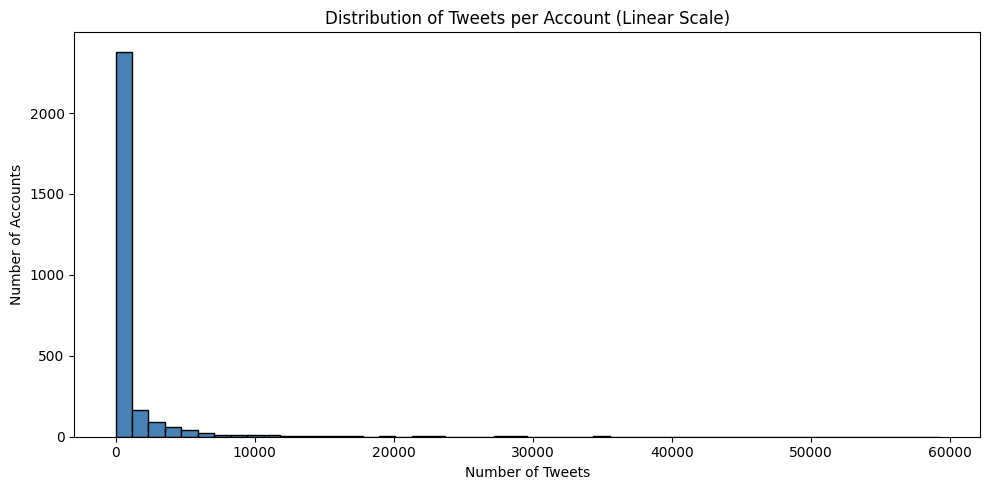

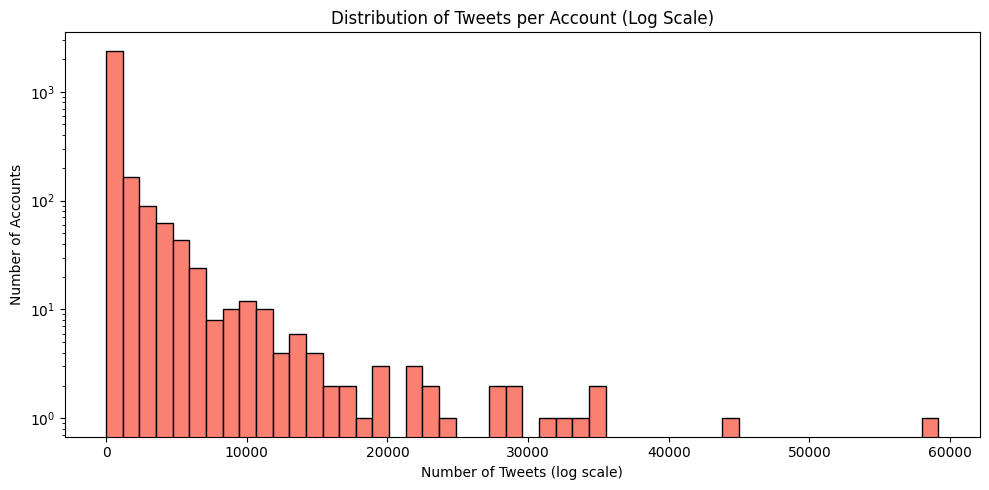

In [ ]:
tweets_per_account_spark = (
    df.groupBy("author")
      .count()
      .withColumnRenamed("count", "tweets_per_account")
)

tweets_per_account = tweets_per_account_spark.toPandas()

plt.figure(figsize=(10, 5))
plt.hist(tweets_per_account["tweets_per_account"], bins=50, color="steelblue", edgecolor="black")
plt.title("Distribution of Tweets per Account (Linear Scale)")
plt.xlabel("Number of Tweets")
plt.ylabel("Number of Accounts")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(tweets_per_account["tweets_per_account"], bins=50, color="salmon", edgecolor="black", log=True)
plt.title("Distribution of Tweets per Account (Log Scale)")
plt.xlabel("Number of Tweets (log scale)")
plt.ylabel("Number of Accounts")
plt.tight_layout()
plt.show()

## Detecting outliers 
- We create new smaller datasets derived from the intial dataset which 

In [ ]:
tweets_per_account = (
    df.groupBy("author")
      .agg(count("*").alias("tweets_per_account"))
)

# high activity datasets
accounts_over_50000 = tweets_per_account.filter(col("tweets_per_account") > 50000)
accounts_over_40000 = tweets_per_account.filter(col("tweets_per_account") > 40000)


print("Accounts with > 50,000 tweets:")
accounts_over_50000.show(truncate=False)

print("\nAccounts with > 40,000 tweets:")
accounts_over_40000.show(truncate=False)

# convertion to pandas for inspection
accounts_50k_pd = accounts_over_50000.toPandas()
accounts_40k_pd = accounts_over_40000.toPandas()

accounts_50k_pd, accounts_40k_pd

# tweets per account
tweets_per_account = (
    df.groupBy("author")
      .agg(count("*").alias("tweets_per_account"))
)

# pandas for percentile calc
tp_pd = tweets_per_account.toPandas()

# # 95th percentile 
p95_threshold = tp_pd["tweets_per_account"].quantile(0.95)

print(f"90th percentile tweet count threshold: {p95_threshold:.2f}")

# nunique accounts above 95th percentile
n_above_90 = (tp_pd["tweets_per_account"] > p95_threshold).sum()

print(f"Number of accounts above 95th percentile: {n_above_90}")

# show as df
accounts_above_90 = tweets_per_account.filter(col("tweets_per_account") > p95_threshold)
accounts_above_90.show(truncate=False)


Accounts with > 50,000 tweets:


+-------+------------------+
|author |tweets_per_account|
+-------+------------------+
|EXQUOTE|59174             |
+-------+------------------+


Accounts with > 40,000 tweets:


+-------------+------------------+
|author       |tweets_per_account|
+-------------+------------------+
|EXQUOTE      |59174             |
|SCREAMYMONKEY|44001             |
+-------------+------------------+



90th percentile tweet count threshold: 4845.60
Number of accounts above 95th percentile: 143
+---------------+------------------+
|author         |tweets_per_account|
+---------------+------------------+
|COOKNCOOKS     |5017              |
|DAILYLOSANGELES|14122             |
|DAILYSANFRAN   |27996             |
|CHRIXMORGAN    |14705             |
|COMRADZAMPOLIT |9581              |
|CASSISHERE     |5661              |
|CHADSLOYER     |5259              |
|CHESPLAYSCHESS |19216             |
|COVFEFENATIONUS|23544             |
|CRYSTAL1JOHNSON|8067              |
|CHAASNTR       |8287              |
|CHICAGODAILYNEW|22148             |
|CURTISBIGMAN   |5021              |
|DAILYSANDIEGO  |14381             |
|BATONROUGEVOICE|10740             |
|BIZGOD         |12156             |
|BOEING_IS_BACK |4932              |
|BOOTH_PRINCE   |9551              |
|BRENTMCCLURE275|7286              |
|BRIANAREGLAND  |6578              |
+---------------+------------------+
only showing top 20